<a href="https://colab.research.google.com/github/CYHYC/DL-pytorch-/blob/main/Tutorial_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision import utils

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 28 * 28

batch_size = 100
lr = 0.0002

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(
                                    mean = [0.5], std = [0.5])   # 1 channel
                                ])

In [ ]:
# 데이터 다운로드
mnist = datasets.MNIST('./mnist/',
                       train = True,
                       transform = transform,
                       download = True)

# dataloader
data_loader = DataLoader(mnist, 
                         batch_size = batch_size, 
                         shuffle = True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


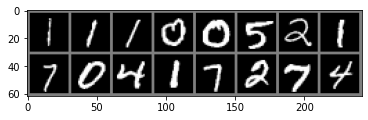

In [ ]:
def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap = 'gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

ex_batch_img, _ = next(iter(data_loader))
imshow_grid(ex_batch_img[:16, :])

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_size = latent_size, hidden_size = hidden_size, image_size = image_size):
        super(Generator, self).__init__()
        self.lin1 = nn.Linear(latent_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, image_size)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.leakyrelu(self.lin1(x))
        x = self.leakyrelu(self.lin2(x))
        x = nn.Tanh()(self.lin3(x))
        return x


class Descriminator(nn.Module):
    def __init__(self, input_size = image_size, hidden_size = hidden_size):
        super(Descriminator, self).__init__()

        self.lin1 = nn.Linear(input_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, 1)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.leakyrelu(self.lin1(x))
        x = self.leakyrelu(self.lin2(x))
        x = nn.Sigmoid()(self.lin3(x))
        return x

In [ ]:
# noise define
def generate_noise(latent_size = latent_size, batch_size = batch_size):
    return torch.randn(batch_size, latent_size)

z = generate_noise().to(device)

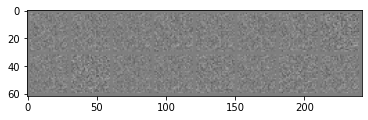

tensor([[0.4994],
        [0.5014],
        [0.4999],
        [0.5009],
        [0.4991]], device='cuda:0', grad_fn=<SliceBackward>)

In [ ]:
G = Generator().to(device)
D = Descriminator().to(device)
img_fake = G(z).view(-1, 1, 28, 28)

imshow_grid(img_fake[:16])

D(G(z))[:5]

In [ ]:
# Optimizer
G_optim = torch.optim.Adam(G.parameters(), lr = lr)
D_optim = torch.optim.Adam(D.parameters(), lr = lr)

# Loss function
criterion = nn.BCELoss()

In [ ]:
# training

def GAN_train(epochs = epochs):
    for epoch in range(epochs):
        for i, (image, _) in enumerate(data_loader):

            image = image.view(-1, 28 * 28 ).to(device)

            z = generate_noise().to(device)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Descriminator 학습

            real_loss = criterion(D(image), real_labels)
            fake_loss = criterion(D(G(z)), fake_labels)

            d_loss = real_loss + fake_loss

            D_optim.zero_grad()
            d_loss.backward()
            D_optim.step()



            # Generator 학습

            g_loss = criterion(D(G(z)), real_labels)
            G_optim.zero_grad()
            g_loss.backward()
            G_optim.step()

        print(f'[{epoch + 1} / {epochs}] D_loss : {d_loss:.4f} \t G_loss : {g_loss:.4f}')     
        if (epoch + 1) % 20 == 0:
            imshow_grid(G(z).view(-1, 1, 28, 28)[:16])

[1 / 200] D_loss : 0.5058 	 G_loss : 3.2212
[2 / 200] D_loss : 0.6285 	 G_loss : 2.5747
[3 / 200] D_loss : 0.6948 	 G_loss : 2.6842
[4 / 200] D_loss : 0.5781 	 G_loss : 2.1060
[5 / 200] D_loss : 0.6110 	 G_loss : 2.4794
[6 / 200] D_loss : 0.8066 	 G_loss : 2.3034
[7 / 200] D_loss : 0.6141 	 G_loss : 2.3204
[8 / 200] D_loss : 0.7380 	 G_loss : 2.0023
[9 / 200] D_loss : 0.7345 	 G_loss : 1.7325
[10 / 200] D_loss : 0.4826 	 G_loss : 2.7706
[11 / 200] D_loss : 0.7271 	 G_loss : 2.3675
[12 / 200] D_loss : 0.6183 	 G_loss : 2.0203
[13 / 200] D_loss : 0.6556 	 G_loss : 1.9178
[14 / 200] D_loss : 0.7563 	 G_loss : 2.0579
[15 / 200] D_loss : 0.7096 	 G_loss : 2.0320
[16 / 200] D_loss : 0.9157 	 G_loss : 2.0645
[17 / 200] D_loss : 0.9169 	 G_loss : 1.5553
[18 / 200] D_loss : 0.8412 	 G_loss : 2.0361
[19 / 200] D_loss : 0.5956 	 G_loss : 2.2360
[20 / 200] D_loss : 0.7810 	 G_loss : 1.6844


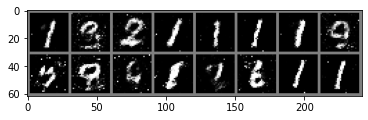

[21 / 200] D_loss : 0.6917 	 G_loss : 1.8349
[22 / 200] D_loss : 0.6435 	 G_loss : 2.6487
[23 / 200] D_loss : 1.0460 	 G_loss : 1.7314
[24 / 200] D_loss : 0.7871 	 G_loss : 1.9958
[25 / 200] D_loss : 0.6433 	 G_loss : 2.0916
[26 / 200] D_loss : 0.5709 	 G_loss : 2.2894
[27 / 200] D_loss : 0.7201 	 G_loss : 1.7990
[28 / 200] D_loss : 0.6851 	 G_loss : 1.8466
[29 / 200] D_loss : 0.6788 	 G_loss : 1.9662
[30 / 200] D_loss : 0.5872 	 G_loss : 2.3929
[31 / 200] D_loss : 0.6489 	 G_loss : 1.8865
[32 / 200] D_loss : 0.8184 	 G_loss : 1.8144
[33 / 200] D_loss : 0.7026 	 G_loss : 2.0002
[34 / 200] D_loss : 0.7323 	 G_loss : 2.0105
[35 / 200] D_loss : 0.6901 	 G_loss : 1.7213
[36 / 200] D_loss : 0.9197 	 G_loss : 1.6430
[37 / 200] D_loss : 0.7883 	 G_loss : 1.8409
[38 / 200] D_loss : 0.8972 	 G_loss : 1.7496
[39 / 200] D_loss : 0.8969 	 G_loss : 1.7343
[40 / 200] D_loss : 0.8885 	 G_loss : 1.8290


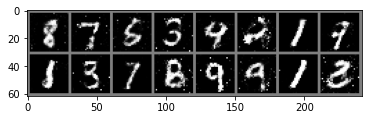

[41 / 200] D_loss : 0.9544 	 G_loss : 1.6301
[42 / 200] D_loss : 0.8396 	 G_loss : 1.8434
[43 / 200] D_loss : 0.8515 	 G_loss : 1.6219
[44 / 200] D_loss : 0.8328 	 G_loss : 1.5058
[45 / 200] D_loss : 0.7287 	 G_loss : 1.7432
[46 / 200] D_loss : 0.6880 	 G_loss : 2.0613
[47 / 200] D_loss : 0.9630 	 G_loss : 1.5517
[48 / 200] D_loss : 0.7493 	 G_loss : 2.2270
[49 / 200] D_loss : 0.6895 	 G_loss : 1.8810
[50 / 200] D_loss : 0.6818 	 G_loss : 1.6473
[51 / 200] D_loss : 0.9760 	 G_loss : 1.6214
[52 / 200] D_loss : 0.6566 	 G_loss : 1.8840
[53 / 200] D_loss : 0.9411 	 G_loss : 1.6415
[54 / 200] D_loss : 0.7136 	 G_loss : 1.7354
[55 / 200] D_loss : 0.8153 	 G_loss : 2.2638
[56 / 200] D_loss : 0.8298 	 G_loss : 1.8600
[57 / 200] D_loss : 0.8086 	 G_loss : 1.8046
[58 / 200] D_loss : 0.8764 	 G_loss : 1.7746
[59 / 200] D_loss : 0.8278 	 G_loss : 1.5004
[60 / 200] D_loss : 1.0070 	 G_loss : 1.7936


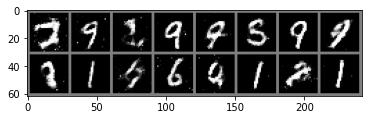

[61 / 200] D_loss : 0.8077 	 G_loss : 1.9242
[62 / 200] D_loss : 0.7714 	 G_loss : 1.6238
[63 / 200] D_loss : 0.6953 	 G_loss : 1.7974
[64 / 200] D_loss : 0.8980 	 G_loss : 1.6694
[65 / 200] D_loss : 0.8344 	 G_loss : 1.7635
[66 / 200] D_loss : 0.9198 	 G_loss : 1.3680
[67 / 200] D_loss : 0.8620 	 G_loss : 1.4914
[68 / 200] D_loss : 0.8381 	 G_loss : 1.9869
[69 / 200] D_loss : 0.8588 	 G_loss : 2.0990
[70 / 200] D_loss : 0.7611 	 G_loss : 1.9003
[71 / 200] D_loss : 0.7550 	 G_loss : 2.1557
[72 / 200] D_loss : 0.9355 	 G_loss : 1.7573
[73 / 200] D_loss : 0.9170 	 G_loss : 1.6095
[74 / 200] D_loss : 0.7920 	 G_loss : 1.7772
[75 / 200] D_loss : 0.8531 	 G_loss : 1.7909
[76 / 200] D_loss : 1.0381 	 G_loss : 1.7318
[77 / 200] D_loss : 0.9147 	 G_loss : 1.6803
[78 / 200] D_loss : 0.9250 	 G_loss : 1.8278
[79 / 200] D_loss : 0.8866 	 G_loss : 1.7633
[80 / 200] D_loss : 0.8848 	 G_loss : 1.7990


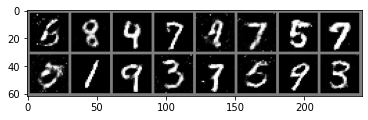

[81 / 200] D_loss : 0.8502 	 G_loss : 1.7841
[82 / 200] D_loss : 0.8373 	 G_loss : 1.6307
[83 / 200] D_loss : 0.8882 	 G_loss : 1.5157
[84 / 200] D_loss : 0.7416 	 G_loss : 1.8563
[85 / 200] D_loss : 0.8004 	 G_loss : 1.7446
[86 / 200] D_loss : 0.8969 	 G_loss : 1.5093
[87 / 200] D_loss : 0.8889 	 G_loss : 1.5304
[88 / 200] D_loss : 0.9884 	 G_loss : 1.4981
[89 / 200] D_loss : 0.7460 	 G_loss : 1.8273
[90 / 200] D_loss : 0.8370 	 G_loss : 2.0975
[91 / 200] D_loss : 0.7459 	 G_loss : 1.8793
[92 / 200] D_loss : 0.8517 	 G_loss : 1.6401
[93 / 200] D_loss : 0.8062 	 G_loss : 1.6919
[94 / 200] D_loss : 0.8145 	 G_loss : 1.8324
[95 / 200] D_loss : 0.8453 	 G_loss : 1.5157
[96 / 200] D_loss : 0.9482 	 G_loss : 1.7493
[97 / 200] D_loss : 0.8245 	 G_loss : 1.6351
[98 / 200] D_loss : 0.6800 	 G_loss : 1.5733
[99 / 200] D_loss : 0.7708 	 G_loss : 1.5642
[100 / 200] D_loss : 0.7963 	 G_loss : 1.6968


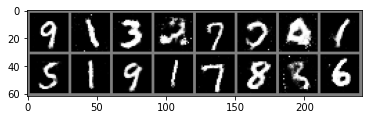

[101 / 200] D_loss : 0.7703 	 G_loss : 1.8036
[102 / 200] D_loss : 0.7993 	 G_loss : 1.5660
[103 / 200] D_loss : 0.7533 	 G_loss : 1.7961
[104 / 200] D_loss : 0.9125 	 G_loss : 1.5567
[105 / 200] D_loss : 0.9474 	 G_loss : 1.3774
[106 / 200] D_loss : 0.7885 	 G_loss : 1.9740
[107 / 200] D_loss : 0.9232 	 G_loss : 1.8747
[108 / 200] D_loss : 0.8470 	 G_loss : 1.8447
[109 / 200] D_loss : 0.8335 	 G_loss : 1.8917
[110 / 200] D_loss : 1.0784 	 G_loss : 1.5631
[111 / 200] D_loss : 0.6142 	 G_loss : 2.1063
[112 / 200] D_loss : 0.9513 	 G_loss : 1.6517
[113 / 200] D_loss : 0.8590 	 G_loss : 1.6816
[114 / 200] D_loss : 0.9320 	 G_loss : 1.4699
[115 / 200] D_loss : 0.8144 	 G_loss : 1.7931
[116 / 200] D_loss : 0.7959 	 G_loss : 1.9335
[117 / 200] D_loss : 0.7875 	 G_loss : 1.8284
[118 / 200] D_loss : 0.7386 	 G_loss : 1.9276
[119 / 200] D_loss : 0.8373 	 G_loss : 2.0359
[120 / 200] D_loss : 0.8152 	 G_loss : 1.5300


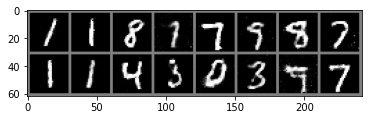

[121 / 200] D_loss : 0.9605 	 G_loss : 1.5998
[122 / 200] D_loss : 0.7975 	 G_loss : 1.3131
[123 / 200] D_loss : 0.7748 	 G_loss : 2.0477
[124 / 200] D_loss : 0.6990 	 G_loss : 1.7676
[125 / 200] D_loss : 0.8717 	 G_loss : 2.0881
[126 / 200] D_loss : 0.7949 	 G_loss : 1.5868
[127 / 200] D_loss : 0.9413 	 G_loss : 1.7072
[128 / 200] D_loss : 0.8823 	 G_loss : 1.7270
[129 / 200] D_loss : 0.7672 	 G_loss : 1.5760
[130 / 200] D_loss : 0.8144 	 G_loss : 1.8543
[131 / 200] D_loss : 0.9010 	 G_loss : 1.5142
[132 / 200] D_loss : 0.7818 	 G_loss : 2.0927
[133 / 200] D_loss : 0.7421 	 G_loss : 1.8457
[134 / 200] D_loss : 0.8134 	 G_loss : 1.8215
[135 / 200] D_loss : 0.7431 	 G_loss : 1.7037
[136 / 200] D_loss : 0.7493 	 G_loss : 1.7382
[137 / 200] D_loss : 0.7327 	 G_loss : 1.8655
[138 / 200] D_loss : 0.7184 	 G_loss : 2.2101
[139 / 200] D_loss : 0.7688 	 G_loss : 1.6163
[140 / 200] D_loss : 0.8368 	 G_loss : 1.7307


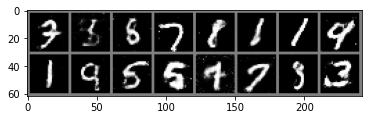

[141 / 200] D_loss : 0.9129 	 G_loss : 1.3137
[142 / 200] D_loss : 0.8964 	 G_loss : 1.4814
[143 / 200] D_loss : 0.8635 	 G_loss : 1.8151
[144 / 200] D_loss : 0.8807 	 G_loss : 1.6885
[145 / 200] D_loss : 0.7705 	 G_loss : 1.7406
[146 / 200] D_loss : 0.7181 	 G_loss : 1.8290
[147 / 200] D_loss : 0.7066 	 G_loss : 1.6419
[148 / 200] D_loss : 0.8564 	 G_loss : 1.7538
[149 / 200] D_loss : 0.7306 	 G_loss : 1.9582
[150 / 200] D_loss : 0.9907 	 G_loss : 1.5328
[151 / 200] D_loss : 0.8933 	 G_loss : 1.8671
[152 / 200] D_loss : 0.7471 	 G_loss : 1.6157
[153 / 200] D_loss : 0.7394 	 G_loss : 1.9002
[154 / 200] D_loss : 0.8468 	 G_loss : 1.6763
[155 / 200] D_loss : 0.8158 	 G_loss : 1.4273
[156 / 200] D_loss : 0.8250 	 G_loss : 1.5736
[157 / 200] D_loss : 0.7154 	 G_loss : 1.8671
[158 / 200] D_loss : 0.7675 	 G_loss : 1.6626
[159 / 200] D_loss : 0.6598 	 G_loss : 2.2961
[160 / 200] D_loss : 1.0195 	 G_loss : 1.6089


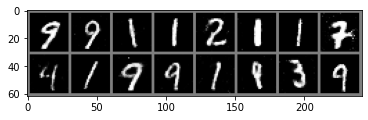

[161 / 200] D_loss : 0.9370 	 G_loss : 1.7826
[162 / 200] D_loss : 0.7468 	 G_loss : 1.5527
[163 / 200] D_loss : 0.7800 	 G_loss : 1.8892
[164 / 200] D_loss : 0.9359 	 G_loss : 2.1839
[165 / 200] D_loss : 0.9024 	 G_loss : 1.9064
[166 / 200] D_loss : 0.6060 	 G_loss : 1.8040
[167 / 200] D_loss : 0.9070 	 G_loss : 2.0300
[168 / 200] D_loss : 0.7996 	 G_loss : 1.5363
[169 / 200] D_loss : 0.8225 	 G_loss : 2.0410
[170 / 200] D_loss : 0.6411 	 G_loss : 1.8720
[171 / 200] D_loss : 0.7644 	 G_loss : 2.0041
[172 / 200] D_loss : 0.8710 	 G_loss : 1.6456
[173 / 200] D_loss : 0.7476 	 G_loss : 1.8351
[174 / 200] D_loss : 0.7372 	 G_loss : 1.9058
[175 / 200] D_loss : 0.7392 	 G_loss : 1.8624
[176 / 200] D_loss : 0.8131 	 G_loss : 1.6048
[177 / 200] D_loss : 0.7419 	 G_loss : 2.0937
[178 / 200] D_loss : 0.8279 	 G_loss : 1.6694
[179 / 200] D_loss : 0.7591 	 G_loss : 1.9142
[180 / 200] D_loss : 0.7796 	 G_loss : 1.7303


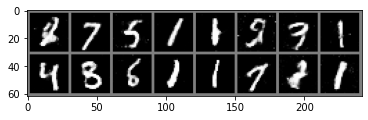

[181 / 200] D_loss : 0.6965 	 G_loss : 2.1037
[182 / 200] D_loss : 0.7427 	 G_loss : 2.0416
[183 / 200] D_loss : 0.7406 	 G_loss : 1.8438
[184 / 200] D_loss : 0.6878 	 G_loss : 1.8371
[185 / 200] D_loss : 0.6230 	 G_loss : 2.1456
[186 / 200] D_loss : 0.8606 	 G_loss : 1.9590
[187 / 200] D_loss : 0.7454 	 G_loss : 1.6179
[188 / 200] D_loss : 0.7419 	 G_loss : 1.6348
[189 / 200] D_loss : 0.8167 	 G_loss : 2.0537
[190 / 200] D_loss : 0.7200 	 G_loss : 1.8993
[191 / 200] D_loss : 0.6993 	 G_loss : 2.0405
[192 / 200] D_loss : 0.8321 	 G_loss : 1.7149
[193 / 200] D_loss : 0.8345 	 G_loss : 1.7416
[194 / 200] D_loss : 0.7150 	 G_loss : 1.7944
[195 / 200] D_loss : 0.7335 	 G_loss : 1.6097
[196 / 200] D_loss : 0.8764 	 G_loss : 2.0436
[197 / 200] D_loss : 0.7362 	 G_loss : 2.2420
[198 / 200] D_loss : 0.8352 	 G_loss : 1.8806
[199 / 200] D_loss : 0.6564 	 G_loss : 1.8801
[200 / 200] D_loss : 0.7456 	 G_loss : 1.9332


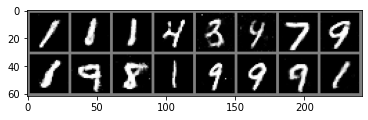

In [ ]:
GAN_train(200)

In [ ]:
# 모델 저장
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')